In [39]:
import pandas as pd
import numpy as np
import sklearn.cluster as skc
import sklearn.preprocessing as skp
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Read in Offline Nearest Neighbor processed data 

In [2]:
data_keys = pd.read_csv('../Processing/FrameContainer/DataRows/Data_keys.csv', header=None)
data_keys = data_keys.iloc[:,0].tolist()

In [ ]:
# for idx in range(0,15):
#     print("Starting recombination for Query Chunk: %d" % idx)
#     path = '../Processing/FrameContainer/QueryRows/'
#     filename = 'Query_Keys_'
#     currentKeys = pd.read(path + filename + idx + '.csv')
    

## Write our files for offline processing

In [ ]:
## Pairwise DTF of all "data-rows" (10000 rows)

In [ ]:
# n_jobs = -1 to turn on parallel
start = timer()
K = skm.pairwise_kernels(dataRows_df, metric=dtw, n_jobs=1)
end = timer()
print(end - start)      

np.savetxt("Processing/DTW_Matrix.out.gz", K, delimiter=',')

# FASTDTW ON SCALE 4E-4 PER PAIR
# AT 10^3 SAMPLES, 10^6 ELS, SO 10^2 SECONDS. Tolerance for production up to 10^4 elements 
# several hours of runtime

In [ ]:
np.savetxt("Processing/DTW_Matrix.out.gz", K, delimiter=',')

In [4]:
K = np.loadtxt('../Processing/DTW_Matrix.out.gz', delimiter=',')

## Hierarchical Clustering

In [5]:
## Run Hierarchical clustering on the matrix 
cluster_ward = skc.AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=K, compute_full_tree=True, linkage='ward')
# cluster_complete = skc.AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=K, compute_full_tree=True, linkage='complete')
# cluster_average = skc.AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=K, compute_full_tree=True, linkage='average')

# Predict the class labels
labels_ward = cluster_ward.fit_predict(K)
# labels_complete = cluster_complete.fit_predict(K)
# labels_average = cluster_average.fit_predict(K)

## Read-in Offline Processed Files

In [11]:
# Helpful dict structure
labeled_data = dict(list(zip(data_keys, labels_ward)))

In [21]:
dataResult_PATH = '../Processing/FrameContainer/DataRows/Data_Keys.csv'
data_keys = pd.read_csv(dataResult_PATH, delimiter='\n', header=None)
data_keys = data_keys[0].values.tolist()

for idx in range(0,15):
    print("Starting join process for Query Chunk: %d" % idx)
    
    outResult_PATH = '../Processing/FrameContainer/OutRows/'
    queryKey_PATH = '../Processing/FrameContainer/QueryRows/'
    
    out_FNAME = 'Out_Rows_'
    query_FNAME = 'Query_Keys_'
    
    queryIndices = pd.read_csv(queryKey_PATH + query_FNAME + str(idx) + '.csv', delimiter='\n', header=None)
    searchResults = pd.read_csv(outResult_PATH + out_FNAME + str(idx) + '.txt', delimiter='\n', header=None)
    
    queryIndices = queryIndices[0].values.tolist()
    searchResults = searchResults[0].values.tolist()
    # Map search results to corresponding data row index
    mappedResults = [data_keys[i] for i in searchResults]
    
    for idx, q in enumerate(queryIndices):
        labeled_data[q] = labeled_data[mappedResults[idx]]

class_data = defaultdict(list)
for k, v in labeled_data.items():
    class_data[v].append(k)

Starting join process for Query Chunk: 0
Starting join process for Query Chunk: 1
Starting join process for Query Chunk: 2
Starting join process for Query Chunk: 3
Starting join process for Query Chunk: 4
Starting join process for Query Chunk: 5
Starting join process for Query Chunk: 6
Starting join process for Query Chunk: 7
Starting join process for Query Chunk: 8
Starting join process for Query Chunk: 9
Starting join process for Query Chunk: 10
Starting join process for Query Chunk: 11
Starting join process for Query Chunk: 12
Starting join process for Query Chunk: 13
Starting join process for Query Chunk: 14


In [24]:
for k in class_data.keys():
    print("Label %d | Class size: %d" % (k, len(class_data[k])))

Label 0 | Class size: 982
Label 1 | Class size: 5908
Label 2 | Class size: 2915
Label 3 | Class size: 2991
Label 4 | Class size: 21433
Label 5 | Class size: 20520
Label 6 | Class size: 89502
Label 7 | Class size: 247
Label 8 | Class size: 186
Label 9 | Class size: 379


## OPTIONAL LOOK IN CLASSES

In [26]:
rawData_df = pd.read_csv('../input/train_1.csv')

/Users/Matthew/miniconda3/envs/bleedingEdge/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/Matthew/miniconda3/envs/bleedingEdge/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Matthew/miniconda3/envs/bleedingEdge/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.w

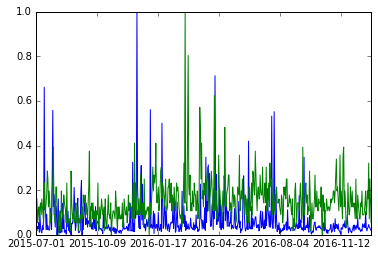

In [58]:
CHECK_LABEL = 6
r1 = class_data[CHECK_LABEL][12]
r2 = class_data[CHECK_LABEL][40]

r1dat = skp.MinMaxScaler().fit_transform(rawData_df.ix[r1,1:].values)
r2dat = skp.MinMaxScaler().fit_transform(rawData_df.ix[r2,1:].values)

first = pd.Series(r1dat, index=rawData_df.columns[1:])
first.plot()

second = pd.Series(r2dat, index=rawData_df.columns[1:])
second.plot()